<a href="https://colab.research.google.com/github/ConfirmatRobotics/deep/blob/main/Segmenation_deeplabv3_deploy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 style="font-size:30px;">DeepLabv3+ with ResNet50_v2 Deploy (edward)</h1>

In [ ]:
!pip install -q git+https://github.com/keras-team/keras-cv.git --upgrade

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 6.8 MB/s eta 0:00:00


In [ ]:
import os
import requests
from zipfile import ZipFile
import glob
from dataclasses import dataclass, field

import random
import numpy as np
import cv2

import tensorflow as tf
import keras_cv

import matplotlib.pyplot as plt

Using TensorFlow backend


## Download dataset and model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!cp -r /content/drive/MyDrive/colab_data/ /content/Water-Bodies-Dataset


## Model Architecture

We will use `resnet50_v2_imagenet` feature extractor on top of the DeepLabv3 Head.

In [7]:
backbone = keras_cv.models.ResNet50V2Backbone.from_preset(preset = "resnet50_v2_imagenet",
                                                          input_shape=(256, 256)+(3,),
                                                          load_weights = True)
model = keras_cv.models.segmentation.DeepLabV3Plus(
        num_classes=2, backbone=backbone,
    )
print(model.summary())

94687928/94687928 [==============================] - 1s 0us/step
Model: "deep_lab_v3_plus"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 model (Functional)          {'P2': (None, 64, 64, 256)   2355660   ['input_1[0][0]']             
                             , 'P5': (None, 8, 8, 2048)   8                                       
                             }                                                                    
                                                                                                  
 spatial_pyramid_pooling (S  (None, 8, 8, 256)            1553817   ['model[0][1]']               
 patialPyramidPool

#### Load Fine-tuned Model Weights

In [8]:
model.load_weights("/content/Water-Bodies-Dataset/deeplabv3_plus_resnet50_v2.h5")

Let us display a few ground truth images along with the corresponding ground truth mask; and have it overlayed on the image input.

In [159]:
MYIMG = "/content/Water-Bodies-Dataset/Water-Bodies-Dataset/Images/water_body_1152.jpg"
pre_image = tf.io.read_file(MYIMG)
pre_image = tf.io.decode_image(pre_image, channels=3)
pre_image.set_shape([None, None, 3])
image = tf.image.resize(images=pre_image, size= (256, 256), method = "bicubic")
image = tf.cast(tf.clip_by_value(image, 0., 255.), tf.float32)
post_image = tf.reshape(image,(1,256,256,3))


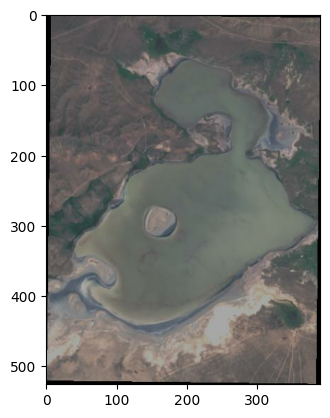

In [59]:
plt.imshow(pre_image)

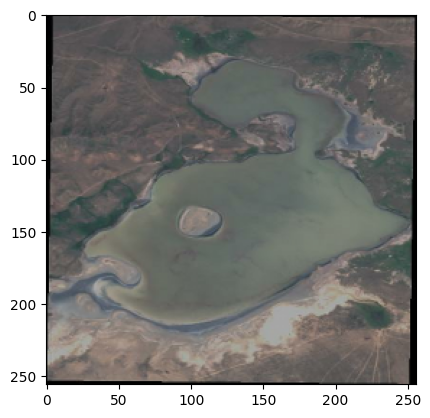

In [160]:
plt.imshow(tf.cast(image, np.uint8))

In [175]:
prediction = model.predict(post_image)
prediction=tf.reshape(prediction,(256,256,2))

1/1 [==============================] - 0s 24ms/step


In [119]:
# Dictionary mapping class IDs to colors.
id2color = {
    0: (0,  10,    10),  # Background
    1: (102, 204, 255),  # Waterbody
 }

In [156]:
def output_to_rgd(numarray, color_map=id2color):
  #newarr = np.empty(numarray.shape[:2] + (1,), dtype=np.uint8)
  output = np.zeros(numarray.shape[:2]+(3,))
  for i in range(len(numarray)):
    for j in range(len(numarray)):
      k = np.argmax(numarray[i,j])
      #newarr[i,j]=np.argmax(numarray[i,j])
      output[i,j] = color_map[k]
  return output.astype(np.uint8)

In [176]:
output=output_to_rgd(prediction.numpy())

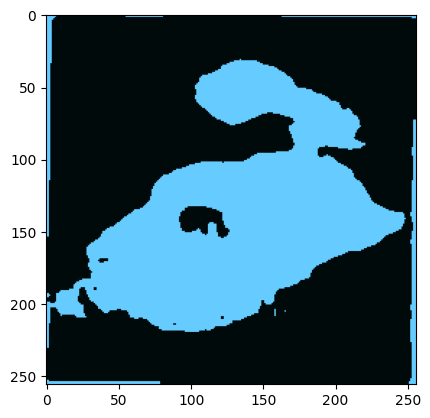

In [177]:
plt.imshow(output)



In [12]:
# Function to overlay a segmentation map on top of an RGB image.
def image_overlay(image, segmented_image):

    alpha = 1.0 # Transparency for the original image.
    beta  = 0.7 # Transparency for the segmentation map.
    gamma = 0.0 # Scalar added to each sum.

    image = image.astype(np.uint8)

    segmented_image = cv2.cvtColor(segmented_image, cv2.COLOR_RGB2BGR)

    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    image = cv2.addWeighted(image, alpha, segmented_image, beta, gamma, image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    return image

In [178]:
overlay = image_overlay(image.numpy(), output)

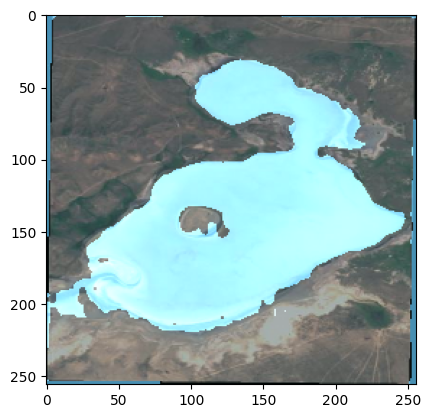

In [179]:
plt.imshow(overlay)
